Demonstration of usage for the Langevin diffuser

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import jax
from jax.scipy.stats import norm

from datasets import generate_gmm, log_gmm_density, gmm_density, score_gmm
from schedulers import linear_schedule
from langevin import LangevinConfig, LangevinDiffusion

ULA for sampling from GMM

In [2]:
# Parameters for the Gaussian Mixture Model (GMM)
prior = [0.5, 0.5]  # Priors for the two components
means = [-1, 1] # Means for each component
stds = [0.5, 0.5] # Standard deviations for each component
num_samples = 10_000 # Number of samples to generate

# Generate RandomKey
key = jax.random.PRNGKey(0)

# Configuration for the Langevin Diffuser
T = 1000
langevin_config = LangevinConfig(
    T=T, step_size=0.01
)
# Instantiate Langevin Diffuser
langevin_difusser = LangevinDiffusion(langevin_config)

# Score function for GMM
score_fn = lambda x : score_gmm(x, prior, means, stds)
# Initialisation from standard normal
x_0 = jax.random.normal(key, shape=(num_samples, 1))
# Split the random key
key, _ = jax.random.split(key)
# Run ULA algorithm
x_T = langevin_difusser.ula_diffusion(x_0, score_fn, key)

100%|██████████| 1000/1000 [00:00<00:00, 1059.77it/s]


Visualisation of samples along with ground-truth density

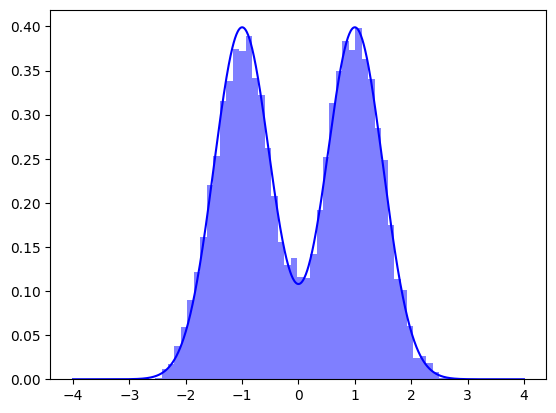

In [8]:
x_values = jnp.linspace(-4, 4, 1000)
gmm_density_values = gmm_density(x_values, prior, means, stds)

plt.hist(np.array(x_T), density=True, bins=50, color='blue', alpha=0.5)
plt.plot(x_values, np.array(gmm_density_values), label='GMM Density', color='blue')
plt.show()

Example of MALA diffusion

In [17]:
# Parameters for the Gaussian Mixture Model (GMM)
prior = [0.5, 0.5]  # Priors for the two components
means = [-1, 1] # Means for each component
stds = [0.5, 0.5] # Standard deviations for each component
num_samples = 10_000 # Number of samples to generate

# Generate RandomKey
key = jax.random.PRNGKey(0)

# Configuration for the Langevin Diffuser
T = 1000
langevin_config = LangevinConfig(
    T=T, step_size=0.5
)
# Instantiate Langevin Diffuser
langevin_difusser = LangevinDiffusion(langevin_config)

# Score function for GMM
score_fn = lambda x : score_gmm(x, prior, means, stds)
log_gmm_density_fn = lambda x : log_gmm_density(x, prior, means, stds)
# Initialisation from standard normal
x_0 = jax.random.normal(key, shape=(num_samples, 1))
# Split the random key
key, _ = jax.random.split(key)
# Run ULA algorithm
x_T = langevin_difusser.mala_diffusion(x_0, log_gmm_density_fn, score_fn, key)

100%|██████████| 1000/1000 [00:03<00:00, 317.73it/s, acc=0.486]


Visualisation of samples along with ground-truth density

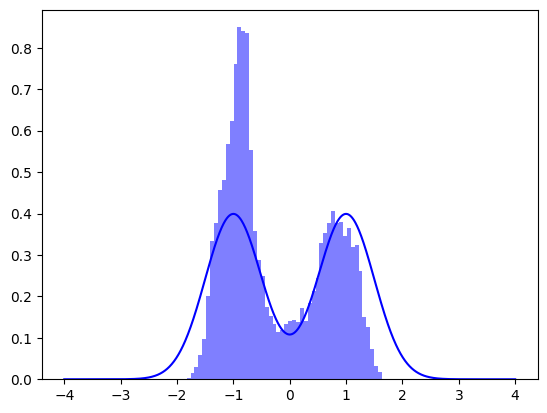

In [18]:
x_values = jnp.linspace(-4, 4, 1000)
gmm_density_values = gmm_density(x_values, prior, means, stds)

plt.hist(np.array(x_T), density=True, bins=50, color='blue', alpha=0.5)
plt.plot(x_values, np.array(gmm_density_values), label='GMM Density', color='blue')
plt.show()

Annealed langevin to sample from normal (scores can be computed by hand)

In [19]:
# Generate RandomKey
key = jax.random.PRNGKey(0)
# x_0 is N(2, 0.01)
# Start the diffusion sampling from a standard normal
_mean_x_0 = 2.
_std_x_0 = 0.1
x_0 = _mean_x_0 + _std_x_0*jax.random.normal(key, shape=(num_samples, 1))

In [20]:
# Definition of the score functions for forward and backward diffusions
# Score function based on noise
_sigma_squared = linear_schedule(T)
_gamma_squared = 1. - _sigma_squared
_gamma = jnp.sqrt(_gamma_squared)
_prod_gamma = jnp.cumprod(_gamma)
_prod_gamma_squared = jnp.cumprod(_gamma_squared)

# Score function for initial normal distribution
def score_fn(x_t: jnp.array, t: int):
    return -(x_t - _prod_gamma[t]*_mean_x_0)/((_prod_gamma[t]*_std_x_0)**2 + (1. - _prod_gamma_squared[t]))

# Score function for initial normal distribution
def score_fn_reversed(x_t: jnp.array, t: int):
    return -(x_t - _prod_gamma[T-t-1]*_mean_x_0)/((_prod_gamma[T-t-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-t-1]))

In [21]:
# Instantiation of LangevinDiffuser
# Configuration for the Langevin Diffuser
T = 1000
steps_per_level = 50
langevin_config = LangevinConfig(
    T=T, step_size=0.01
)
langevin_diffuser = LangevinDiffusion(langevin_config)

# Run backward diffusion
# x_T is N(0, 1)
key, _ = jax.random.split(key)
x_T = jax.random.normal(key, shape=(num_samples, 1))
# Split the random key
key, _ = jax.random.split(key)
x_1 = langevin_diffuser.annealed_langevin(x_T, score_fn_reversed, steps_per_level, key, (1. - _prod_gamma_squared))
# Last sample has noise, that needs to be removed
x_0 = (x_1 + (1. - _prod_gamma_squared[0])*score_fn(x_1, 0))/_gamma[0]

100%|██████████| 1000/1000 [00:20<00:00, 48.06it/s]


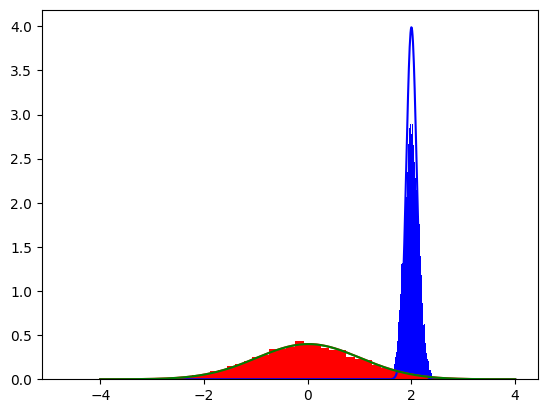

In [22]:
# Visualisation code
x_values = jnp.linspace(-4, 4, 1000)
density_x_0 = norm.pdf(x_values, loc=_mean_x_0, scale=_std_x_0)
density_x_T = norm.pdf(x_values, loc=_mean_x_0*_prod_gamma[T-1], scale=jnp.sqrt(_prod_gamma[T-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-1]))
density_standard = norm.pdf(x_values, loc=_mean_x_0*_prod_gamma[T-1], scale=jnp.sqrt(_prod_gamma[T-1]*_std_x_0)**2 + (1. - _prod_gamma_squared[T-1]))
plt.hist(np.array(x_0), density=True, bins=50, color='blue')
plt.hist(np.array(x_T), density=True, bins=50, color='red')
plt.plot(x_values, np.array(density_x_0), label='Density x_0', color='blue')
plt.plot(x_values, np.array(density_x_T), label='Density x_T', color='red')
plt.plot(x_values, np.array(density_standard), label='Density Standard', color='green')
plt.show()